In [1]:
import os
import sys
import pandas as pd
import datetime as dt
sys.path.append("../lib/")
from utils import *
from preprocessing_analysis import *
import statsmodels.api as sm
from datetime import timedelta
import matplotlib.pyplot as plt
from forecasting_analysis import sarimax_forecasting, save_sarimax_results, \
                                 plot_model_forecasting, accuracy_metric

## Daily Load Sum SARIMA Forecasting

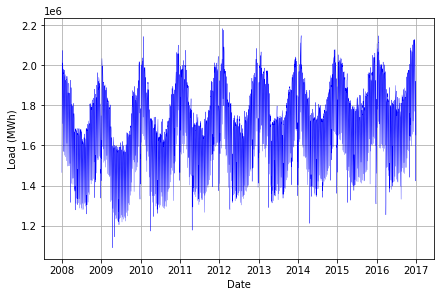

,Date,Hour,Minutes,Load,Load_denoised,Load_lin,Load_detrend
0,2008-01-01,11.621053,22.736842,1464842.5,1.464816e+06,1.650746e+06,-185903.375157
1,2008-01-02,11.500000,22.500000,1900414.4,1.900407e+06,1.650792e+06,249622.844845
2,2008-01-03,11.500000,22.500000,2023765.7,2.023846e+06,1.650837e+06,372928.464848
3,2008-01-04,11.500000,22.500000,2074081.7,2.074155e+06,1.650883e+06,423198.784850
4,2008-01-05,11.500000,22.500000,1910250.4,1.910096e+06,1.650929e+06,259321.804852
...,...,...,...,...,...,...,...
3283,2016-12-27,11.500000,22.500000,1788972.9,1.789020e+06,1.800713e+06,-11740.407468
3284,2016-12-28,11.500000,22.500000,1920741.9,1.920609e+06,1.800759e+06,119982.912534
3285,2016-12-29,11.500000,22.500000,1908350.9,1.908360e+06,1.800805e+06,107546.232537
3286,2016-12-30,11.500000,22.500000,1875408.2,1.875350e+06,1.800850e+06,74557.852539


In [2]:
filepath = '../Data/'
df_D = pd.read_csv(filepath + 'Poland_Load_D_resampled.csv', parse_dates=['Date'])

plot_data(
    df=df_D,
    file='Poland_Load_D_resampled',
    lw=0.3,
    feature='Load'
)

df_D

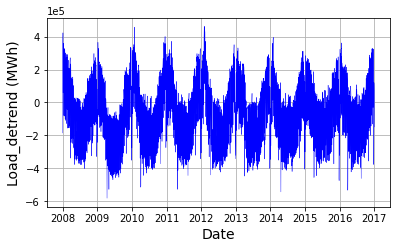

,Hour,Minutes,Load,Load_denoised,Load_lin,Load_detrend
Date,,,,,,
2008-01-01,11.621053,22.736842,1464842.5,1.464816e+06,1.650746e+06,-185903.375157
2008-01-02,11.500000,22.500000,1900414.4,1.900407e+06,1.650792e+06,249622.844845
2008-01-03,11.500000,22.500000,2023765.7,2.023846e+06,1.650837e+06,372928.464848
2008-01-04,11.500000,22.500000,2074081.7,2.074155e+06,1.650883e+06,423198.784850
2008-01-05,11.500000,22.500000,1910250.4,1.910096e+06,1.650929e+06,259321.804852
...,...,...,...,...,...,...
2016-12-27,11.500000,22.500000,1788972.9,1.789020e+06,1.800713e+06,-11740.407468
2016-12-28,11.500000,22.500000,1920741.9,1.920609e+06,1.800759e+06,119982.912534
2016-12-29,11.500000,22.500000,1908350.9,1.908360e+06,1.800805e+06,107546.232537


In [4]:
plot_data(
    df=df_D,
    file='Poland_Load_D_resampled_detrend',
    lw=0.4,
    feature='Load_detrend'
)

df_D.set_index('Date', inplace=True)

df_D

In [5]:
daily_Load = df_D[['Load_detrend']].copy()
daily_Load

,Load_detrend
Date,
2008-01-01,-185903.375157
2008-01-02,249622.844845
2008-01-03,372928.464848
2008-01-04,423198.784850
2008-01-05,259321.804852
...,...
2016-12-27,-11740.407468
2016-12-28,119982.912534
2016-12-29,107546.232537


In [6]:
cut_dates_days = [dt.datetime(2016, 12, 25)] \
                 + [df_D.index[-1] - timedelta(days=i*30-1) for i in range(1, 12)] \
                 + [dt.datetime(2016, 1, 2)]

[1 + (df_D.index[-1] - date).days for date in cut_dates_days]

[7, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]

2016-12-25 00:00:00


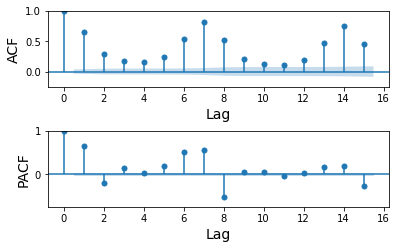

2016-12-02 00:00:00


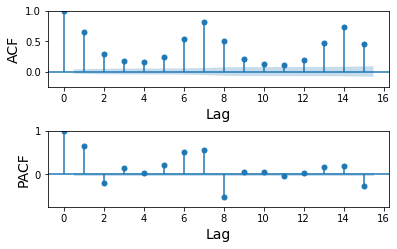

2016-11-02 00:00:00


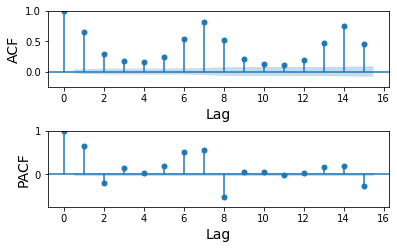

2016-10-03 00:00:00


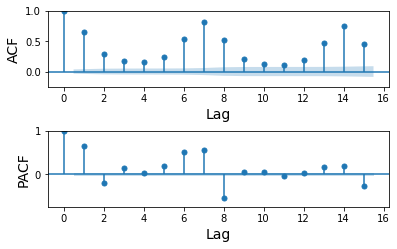

2016-09-03 00:00:00


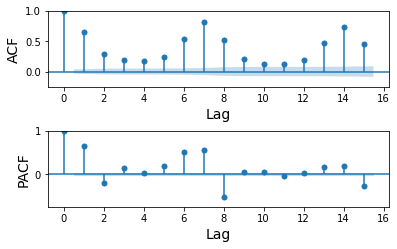

2016-08-04 00:00:00


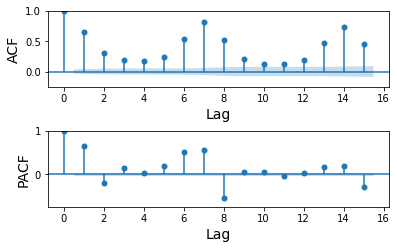

2016-07-05 00:00:00


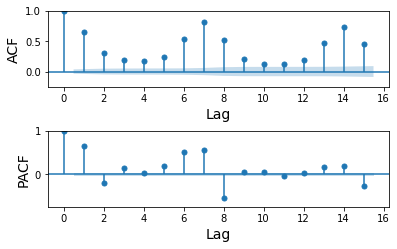

2016-06-05 00:00:00


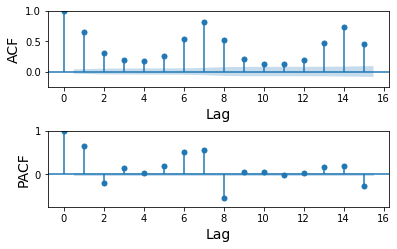

2016-05-06 00:00:00


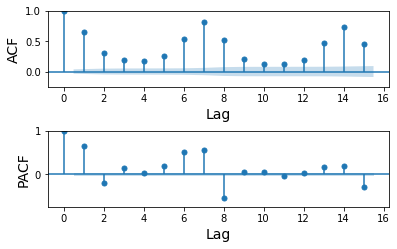

2016-04-06 00:00:00


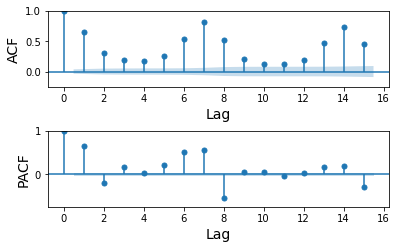

2016-03-07 00:00:00


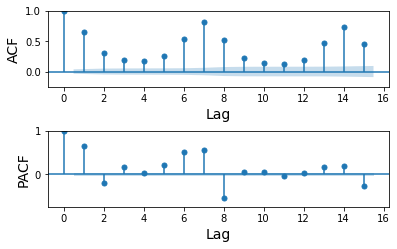

2016-02-06 00:00:00


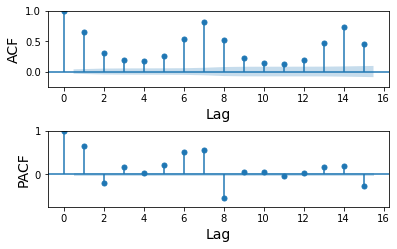

2016-01-02 00:00:00


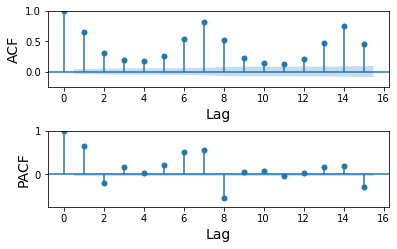

In [7]:
import warnings 
warnings.filterwarnings('ignore')

for cut_date in cut_dates_days:
    print(cut_date)
    train_set = daily_Load[daily_Load.index < cut_date]
    
    sTest = StationarityTests()
    sTest.kpss_Stationarity_Test(train_set['Load_detrend'])
    
    test_lag = sTest.Results.loc['# Lags Used'][0]
    test_result = sTest.Results.loc['Is the time series stationary?'][0]

    ax = latex_settings(nrows=2, ncols=1)
    lag = 15

    fig = sm.graphics.tsa.plot_acf(train_set, lags=lag, ax=ax[0], title=None)
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('ACF')
    ax[0].set_ylim(-0.25, 1.)

    fig = sm.graphics.tsa.plot_pacf(train_set, lags=lag, ax=ax[1], title=None)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('PACF')
    ax[1].set_ylim(-0.75, 1.)

    date = cut_date.strftime(format='%Y-%m-%d')
    filepath = '../Images/SARIMAX/ACF_PACF/'
    file = f'ACF_PACF_days_{date}_{test_lag}_{test_result}'
    if os.path.isfile(filepath + file):
        pass
    else:  
        plt.savefig(f'{filepath}{file}.png', dpi=800, trasparent=True)

    plt.show()
    plt.close()


In [8]:
ax = latex_settings(nrows=2, ncols=1)

lag = 15

fig = sm.graphics.tsa.plot_acf(daily_Load, lags=lag, ax=ax[0], title=None)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_ylim(-0.25, 1.)

fig = sm.graphics.tsa.plot_pacf(daily_Load, lags=lag, ax=ax[1], title=None)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_ylim(-0.75, 1.)

filepath = '../Images/SARIMAX/ACF_PACF/'
file = 'ACF_PACF_days'
if os.path.isfile(filepath + file):
    pass
else:  
    plt.savefig(f'{filepath}{file}.png', dpi=800, trasparent=True)

plt.close()

In [ ]:
sTest = StationarityTests()
sTest.kpss_Stationarity_Test(daily_Load['Load_detrend'])

sTest.Results

c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Test Results
KPSS Test Statistic,0.303181
P-Value,0.1
# Lags Used,1
# Observations Used,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
Critical Value (10%),0.347
Critical Value (5%),0.463
Critical Value (2.5%),0.574
Critical Value (1%),0.739
Is the time series stationary?,Yes


In [7]:
def plot_model_forecasting_trial(df, cut_day, model, feature = 'Load',
                           file=None, ax = None, legend = None, xlabel=None):
   
    freq = df.index.inferred_freq 
    if freq == 'W-SUN':
        weeks = 52
        n_weeks = ((df.index[-1] - cut_day).days + 1) // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        weeks = 2
        n_days = (df.index[-1] - cut_day).days + 1
        time_interval = n_days
        interval_type = 'days'
        
    date = cut_day - dt.timedelta(weeks=weeks)
    cut_mask = df.index >= cut_day
    date_mask = df.index > date
    
    if not ax:
        ax = latex_settings()
        legend = True
        xlabel = 'Date'
        file = f'{model}_{freq}_{time_interval}{interval_type}.png'
    
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1, legend=legend)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax,
                                                 color=['g', 'orange'],
                                                 lw=1, legend=legend)
    ax.fill_between(x=df[date_mask].index,
                    y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast,
                    color='orange', alpha=0.5, lw=1)
    ax.grid()
    ax.set_ylabel('Load (MW)')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_xlabel(xlabel)
    ax.set_title(f'Poland Electricity Load ({time_interval} {interval_type})')
    
    if legend:
        leg = plt.legend(loc="lower left", ncol=4, fancybox=True,
                         framealpha=0.5, fontsize=7.5,
                         labels=['Train set', 'Test set', 'Forecast', '95% CI'])
        fancy_legend(leg)

In [ ]:
model = 'SARIMAX'
results_path = f'../Results/{model}/'
dir = os.listdir(results_path)
# if Empty directory
if len(dir) == 0:
    for date in cut_dates_days:
        forecast  = sarimax_forecasting(daily_Load, date, (4,0,5), (1,1,0,7))
        save_sarimax_results(forecast, df_D, 'SARIMAX')
else:
    pass

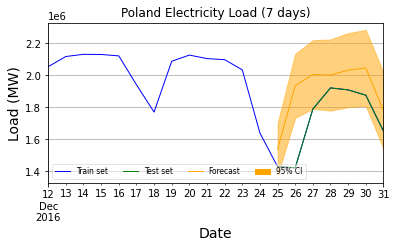

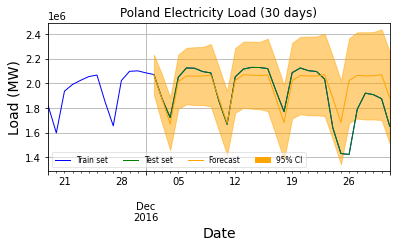

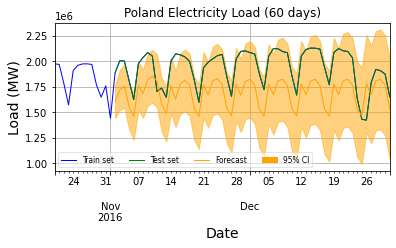

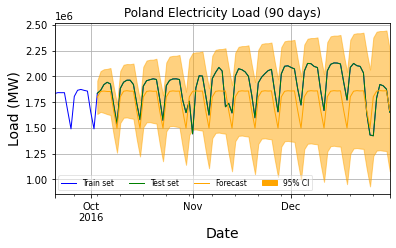

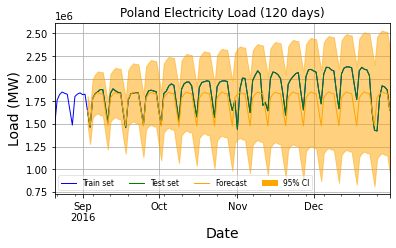

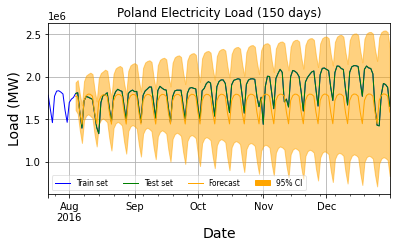

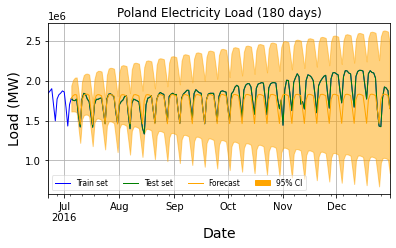

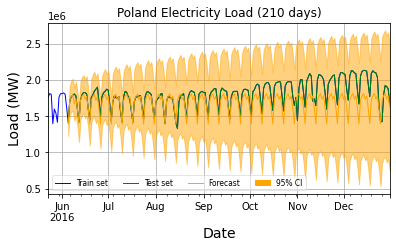

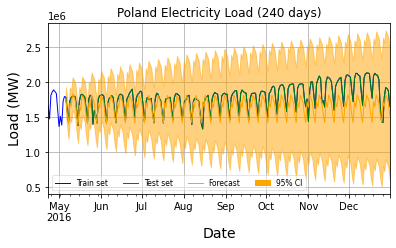

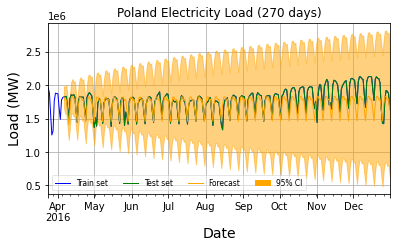

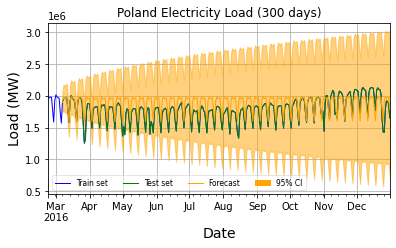

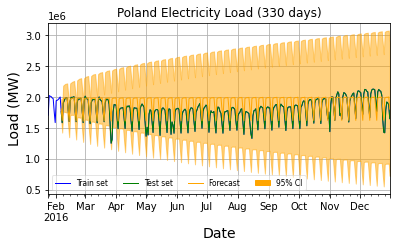

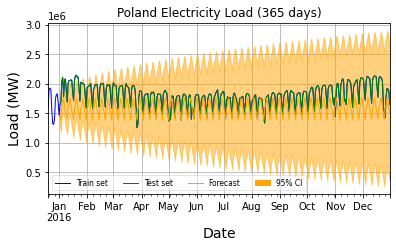

In [9]:
freq = 'D'
model = 'SARIMAX'
results_path = f'../Results/{model}/'
files = get_result_filenames(results_path, freq)

dfs_D = []
for file, cut_date in zip(files, cut_dates_days):
    res = pd.read_csv(
        results_path + file, index_col=['Date'], parse_dates=['Date']
        )
    tmp = df_D[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model='SARIMAX')
    
    dfs_D.append(tmp)

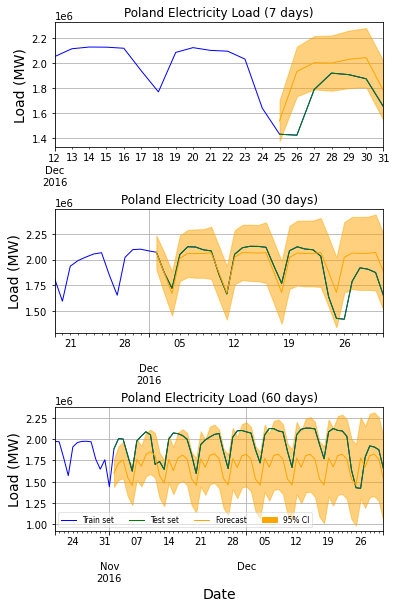

In [92]:
panels = ['(a)', '(b)', '(c)']
axs = latex_settings(len(dfs_D[:3]), 1, 2.5)
legends = [False, False, True]
xlabels = [None, None, 'Date']

for i, tmp in enumerate(dfs_D[:3]):
    plot_model_forecasting_trial(
        df=tmp, cut_day=cut_dates_days[i], model=model,
        ax=axs[i], legend=legends[i], xlabel=xlabels[i]
        )
    # label physical distance in and down:
    axs[i].annotate(xy=(0.01, 0.97), text=panels[i], xycoords='axes fraction', 
            fontsize='medium', verticalalignment='top', weight='bold',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))

model = 'PSF' 
filepath_img = f'../Images/{model}/' 
plt.savefig(filepath_img + 'SARIMAX_D.png', dpi=800, trasparent=True)
plt.show()
plt.close()

In [16]:
table_D = accuracy_metric(dfs_D, cut_dates_days)
table_D

,cut date,accuracy,mape,rel err
0,2016-12-25,71.43,11.86,22.55
1,2016-12-02,96.67,5.89,29.29
2,2016-11-02,83.33,13.35,43.49
3,2016-10-03,98.89,8.19,47.87
4,2016-09-03,100.0,6.96,55.54
5,2016-08-04,99.33,8.27,62.35
6,2016-07-05,99.44,5.98,64.89
7,2016-06-05,100.0,6.96,72.14
8,2016-05-06,99.58,7.88,77.5
9,2016-04-06,99.63,5.39,79.87


In [28]:
filename = 'SARIMAX_D_accuracy.tex'
filepath = '../Results/Latex_tables/'

        
latex_table_generator(table_D, filepath+filename, float_format=None)

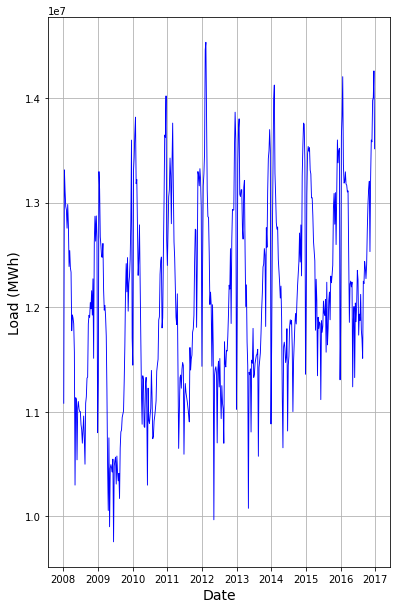

,Date,Hour,Minutes,Load,Load_lin,Load_detrend
0,2008-01-06,11.52,22.53913,11081984.7,1.153853e+07,-4.565480e+05
1,2008-01-13,11.50,22.50000,13312844.7,1.154083e+07,1.772013e+06
2,2008-01-20,11.50,22.50000,13109142.4,1.154313e+07,1.566011e+06
3,2008-01-27,11.50,22.50000,12963823.6,1.154543e+07,1.418392e+06
4,2008-02-03,11.50,22.50000,12932126.7,1.154773e+07,1.384396e+06
...,...,...,...,...,...,...
464,2016-11-27,11.50,22.50000,13581364.1,1.260550e+07,9.758681e+05
465,2016-12-04,11.50,22.50000,13978036.2,1.260780e+07,1.370241e+06
466,2016-12-11,11.50,22.50000,14004313.2,1.261009e+07,1.394218e+06
467,2016-12-18,11.50,22.50000,14259329.9,1.261239e+07,1.646935e+06


In [12]:
filepath = '../Data/'
df_W = pd.read_csv(filepath + 'Poland_Load_W_resampled.csv', parse_dates=['Date'])

plot_data(
    df=df_W,
    file='Poland_Load_W_resampled',
    lw=0.9,
    feature='Load'
)

df_W

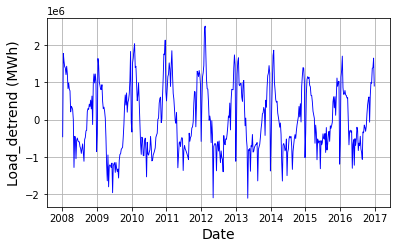

,Hour,Minutes,Load,Load_lin,Load_detrend
Date,,,,,
2008-01-06,11.52,22.53913,11081984.7,1.153853e+07,-4.565480e+05
2008-01-13,11.50,22.50000,13312844.7,1.154083e+07,1.772013e+06
2008-01-20,11.50,22.50000,13109142.4,1.154313e+07,1.566011e+06
2008-01-27,11.50,22.50000,12963823.6,1.154543e+07,1.418392e+06
2008-02-03,11.50,22.50000,12932126.7,1.154773e+07,1.384396e+06
...,...,...,...,...,...
2016-11-27,11.50,22.50000,13581364.1,1.260550e+07,9.758681e+05
2016-12-04,11.50,22.50000,13978036.2,1.260780e+07,1.370241e+06
2016-12-11,11.50,22.50000,14004313.2,1.261009e+07,1.394218e+06


In [13]:
plot_data(
    df=df_W,
    file='Poland_Load_W_resampled_detrend',
    lw=0.9,
    feature='Load_detrend'
)

df_W.set_index('Date', inplace=True)

df_W

In [82]:
weekly_Load = df_W[['Load_detrend']].copy()
weekly_Load

,Load_detrend
Date,
2008-01-06,-4.565480e+05
2008-01-13,1.772013e+06
2008-01-20,1.566011e+06
2008-01-27,1.418392e+06
2008-02-03,1.384396e+06
...,...
2016-11-27,9.758681e+05
2016-12-04,1.370241e+06
2016-12-11,1.394218e+06


2016-07-01 00:00:00


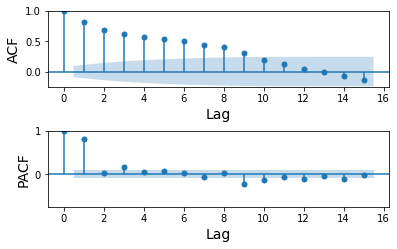

2015-07-01 00:00:00


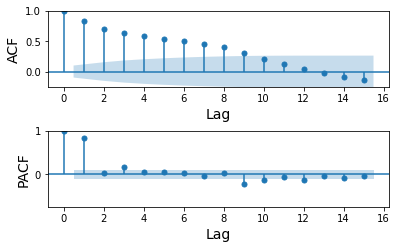

2014-07-01 00:00:00


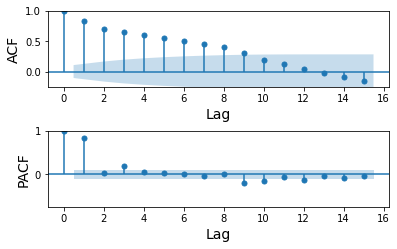

In [83]:
for cut_date in cut_dates_weeks:
    print(cut_date)
    train_set = weekly_Load[weekly_Load.index < cut_date]
    
    sTest = StationarityTests()
    sTest.kpss_Stationarity_Test(train_set['Load_detrend'])

    test_lag = sTest.Results.loc['# Lags Used'][0]
    test_result = sTest.Results.loc['Is the time series stationary?'][0]

    ax = latex_settings(nrows=2, ncols=1)
    lag = 15

    fig = sm.graphics.tsa.plot_acf(train_set, lags=lag, ax=ax[0], title=None)
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('ACF')
    ax[0].set_ylim(-0.25, 1.)

    fig = sm.graphics.tsa.plot_pacf(train_set, lags=lag, ax=ax[1], title=None)
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('PACF')
    ax[1].set_ylim(-0.75, 1.)

    date = cut_date.strftime(format='%Y-%m-%d')
    filepath = '../Images/SARIMAX/ACF_PACF/'
    file = f'ACF_PACF_weeks_{date}_{test_lag}_{test_result}'
    if os.path.isfile(filepath + file):
        pass
    else:  
        plt.savefig(f'{filepath}{file}.png', dpi=800, trasparent=True)

    plt.show()
    plt.close()

c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
<ipython-input-6-9771d16b85ec>:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'{filepath}{file}.png', dpi=800, trasparent=True)


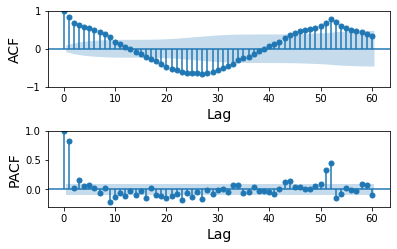

In [6]:
ax = latex_settings(nrows=2, ncols=1)

lag = 60

fig = sm.graphics.tsa.plot_acf(weekly_Load, lags=lag, ax=ax[0], title=None)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')

fig = sm.graphics.tsa.plot_pacf(weekly_Load, lags=lag, ax=ax[1], title=None)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_ylim(-0.3, 1.)


filepath = '../Images/SARIMAX/ACF_PACF/'
file = 'ACF_PACF_weeks'
if os.path.isfile(filepath + file):
    pass
else:  
    plt.savefig(f'{filepath}{file}.png', dpi=800, trasparent=True)

In [23]:
sTest = StationarityTests()
sTest.kpss_Stationarity_Test(weekly_Load['Load_detrend'])

sTest.Results

c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Test Results
KPSS Test Statistic,0.083453
P-Value,0.1
# Lags Used,1
# Observations Used,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
Critical Value (10%),0.347
Critical Value (5%),0.463
Critical Value (2.5%),0.574
Critical Value (1%),0.739
Is the time series stationary?,Yes


In [14]:
cut_dates_weeks = [
    dt.datetime(2016, 7, 1),
    dt.datetime(2015, 7, 1),
    dt.datetime(2014, 7, 1)
    ]

model = 'SARIMAX'
results_path = f'../Results/{model}/'

dir = os.listdir(results_path)
# if Empty directory
if len(dir) == 0:
    for date in cut_dates_weeks:
        forecast = sarimax_forecasting(weekly_Load, date, (1,0,9), (2,1,0,52)) 
        save_sarimax_results(forecast, df_W, model='SARIMAX')
else:
    pass

In [29]:
for date in cut_dates_weeks:
    forecast = sarimax_forecasting(weekly_Load, date, (1,0,9), (2,1,0,52)) 
    save_sarimax_results(forecast, df_W, model='SARIMAX')

c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
c:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


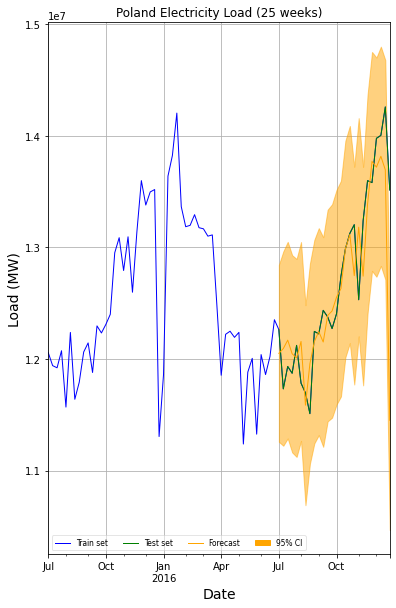

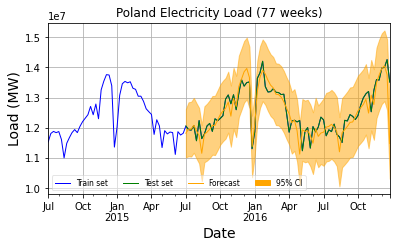

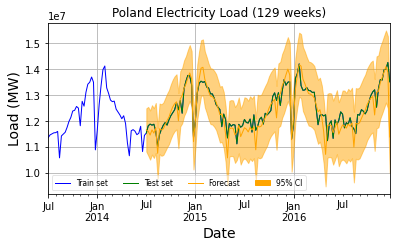

In [24]:
freq = 'W-SUN'
model = 'SARIMAX'
results_path = f'../Results/{model}/'
files = get_result_filenames(results_path, freq)

dfs_W = []
for file, cut_date in zip(files, cut_dates_weeks):
    res = pd.read_csv(
        results_path + file, index_col=['Date'], parse_dates=['Date']
        )
    tmp = df_W[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model='SARIMAX')
    
    dfs_W.append(tmp)

<ipython-input-26-98b67883d77c>:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "trasparent" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filepath_img + 'SARIMAX_W-SUN_weeks.png', dpi=800, trasparent=True)


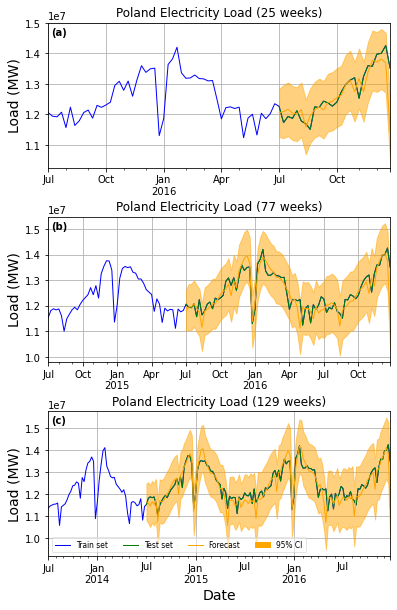

In [26]:
panels = ['(a)', '(b)', '(c)']
axs = latex_settings(len(dfs_W[:3]), 1, 2.5)
legends = [False, False, True]
xlabels = [None, None, 'Date']

for i, tmp in enumerate(dfs_W[:3]):
    plot_model_forecasting_trial(
        df=tmp, cut_day=cut_dates_weeks[i], model=model,
        ax=axs[i], legend=legends[i], xlabel=xlabels[i]
        )
    # label physical distance in and down:
    axs[i].annotate(xy=(0.01, 0.97), text=panels[i], xycoords='axes fraction', 
            fontsize='medium', verticalalignment='top', weight='bold',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))


filepath_img = f'../Images/{model}/' 
plt.savefig(filepath_img + 'SARIMAX_W-SUN_weeks.png', dpi=800, trasparent=True)
plt.show()
plt.close()

In [48]:
table_W = accuracy_metric(dfs_W, cut_dates_weeks)
table_W

,cut date,accuracy,mape,rel err
0,2016-07-01,96.15,2.37,14.91
1,2015-07-01,97.44,2.17,16.85
2,2014-07-01,98.46,2.19,19.2


In [18]:
filename = 'SARIMAX_W-SUN_accuracy.tex'
filepath = '../Results/Latex_tables/'

        
latex_table_generator(table_W, filepath+filename)